**Findings during data preprocessing:**


*   No Readme file is provided
*   The data is sampled at 128Hz (consecutive two rows has a time gap of 7.8125ms)
*   There are many time gaps of different lengths between original segments across different signals for every patient 
*   Patient 01849 has a time gap of 15.625ms within one segment
*   Patient 00095 and icu patient are removed because they have only a few broken segments

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import copy
import multiprocessing
import timeit
from datetime import datetime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# get list of patient folders
path = '/content/drive/My Drive/epi_data_folders'
os.chdir(path)
!ls

MSEL_00172  MSEL_00502	MSEL_01676  MSEL_01808	MSEL_01844  rapidsai-csp-utils
MSEL_00182  MSEL_01097	MSEL_01709  MSEL_01828	MSEL_01849  start_end.csv
MSEL_00501  MSEL_01575	MSEL_01763  MSEL_01842	MSEL_01870  start_end.gsheet


In [ ]:
# remove existing concat_data folders
for dir in os.listdir("./"):
  if "MSEL" in dir and "concat_data" in os.listdir("./"+dir):
    folder = "./"+dir+"/concat_data"
    shutil.rmtree(folder)

In [ ]:
# get all patient_nums
patient_nums = []
for dir in os.listdir("./"):
  if "MSEL" in dir:
    patient_nums.append(dir[-5:])
print(patient_nums)

['01575', '01828', '01709', '01870', '01842', '01844', '01097', '00182', '01676', '01849', '01808', '00501', '00172', '01763', '00502']


In [ ]:
# the time of the data 1564081654000 is in ms
datetime.fromtimestamp(1564081654)

datetime.datetime(2019, 7, 25, 19, 7, 34)

**Since the original segments are of different lengths, we will concatenate them together and resplit**

In [ ]:
def concat(patient_num, channel_name):
  cur_dir = "/content/drive/My Drive/epi_data_folders/MSEL_{}/Empatica-{}".format(patient_num, channel_name)
  os.chdir(cur_dir)
  seg_num = len(os.listdir("./"))  # get the number of files in the folder
                                   # the way it sorts the filename with numbers is "1", "11", "2"
  df_lsts = []
  for i in range(seg_num):
    filename = "MSEL_{}_Empatica-{}_{}_segment_{}.parquet".format(patient_num, channel_name, channel_name, i)
    df = pd.read_parquet(filename, engine="auto")
    if i != 0:
      pre = df_lsts[-1]["time"][df_lsts[-1].shape[0] - 1]
      next = df["time"][0]

      # fill the time gaps with np.nans
      if next - pre != 7.8125:    # 128Hz corresponds to 7.8125ms
        gap = pd.DataFrame(np.arange(pre, next, 7.8125))    # generate a timestamp every 7.8125ms
        gap = gap.drop(0) 
        nan_col = np.empty((gap.shape[0],1)) 
        nan_col.fill(np.nan)
        combined = pd.DataFrame(np.c_[gap, nan_col])    # add a column of np.nan to the timestamp
        combined.rename({0: "time", 1: "data"}, axis = 1, inplace = True)
        df_lsts.append(combined)

    df_lsts.append(df)

  df_concat = pd.concat(df_lsts)
  df_concat.rename(columns = {"data": "{}".format(channel_name)}, inplace = True)
  df_concat.reset_index(inplace=True)
  df_concat.drop(columns=['index'], inplace=True)

  return df_concat

In [ ]:
# concatenate for signal ["BVP", "EDA", "HR", "TEMP"]
def concat_forall(patient_num):
  for feature in ["BVP", "EDA", "HR", "TEMP"]:
    df_concat = concat(patient_num, feature)
    df_concat.to_parquet("/content/drive/MyDrive/epi_data_folders/MSEL_{}/{}_{}.parquet".format(patient_num, patient_num, feature))

In [ ]:
# since the directory name of Acc are different from other singals, we wrtie 
# a separate function for it
def concat_Acc(patient_num):
  cur_dir = "/content/drive/MyDrive/epi_data_folders/MSEL_{}/Empatica-ACC".format(patient_num)
  os.chdir(cur_dir)
  seg_num = len(os.listdir("./"))
  seg_num = int(seg_num / 4) # get the number of files in the folder
                      # the way it sorts the filename with numbers is "1", "11", "2"

  for coordinate in ["Mag", "x", "y", "z"]:
    df_lsts = []
    for i in range(seg_num):
      filename = "MSEL_{}_Empatica-ACC_Acc {}_segment_{}.parquet".format(patient_num, coordinate, i)
      df = pd.read_parquet(filename, engine="auto")
      if i != 0:
        pre = df_lsts[-1]["time"][df_lsts[-1].shape[0] - 1]
        next = df["time"][0]

        if next - pre != 7.8125:    # 128Hz corresponds to 7.8125ms
          gap = pd.DataFrame(np.arange(pre, next, 7.8125))    # generate a timestamp every 7.8125ms
          gap = gap.drop(0) 
          nan_col = np.empty((gap.shape[0],1)) 
          nan_col.fill(np.nan)
          combined = pd.DataFrame(np.c_[gap, nan_col])    # add a column of np.nan to the timestamp
          combined.rename({0: "time", 1: "data"}, axis = 1, inplace = True)
          df_lsts.append(combined)
          
      df_lsts.append(df)
    df_concat = pd.concat(df_lsts)
    df_concat.rename(columns = {"data": "{}".format(coordinate)}, inplace = True)
    df_concat.reset_index(inplace=True)
    df_concat.drop(columns=['index'], inplace=True)
    df_concat.to_parquet("/content/drive/MyDrive/epi_data_folders/MSEL_{}/{}_{}.parquet".format(patient_num, patient_num, coordinate))

In [ ]:
# concatenate for all signals and all patients 
for patient_num in patient_nums:
  concat_forall(patient_num)
  concat_Acc(patient_num)

In [ ]:
# move all concatenated files to a separate directory
for patient_num in patient_nums:
  path = "/content/drive/MyDrive/epi_data_folders/MSEL_{}/concat_data".format(patient_num)
  os.mkdir(path)
  for signal in ["BVP", "EDA", "HR", "Mag", "TEMP", "x", "y", "z"]:
    shutil.move("/content/drive/MyDrive/epi_data_folders/MSEL_{}/{}_{}.parquet".format(patient_num, patient_num, signal), "/content/drive/MyDrive/epi_data_folders/MSEL_{}/concat_data/{}_{}.parquet".format(patient_num, patient_num, signal))

In [ ]:
# This function is used to find one exact position of gaps bigger than 7.8125ms
# with it, we find that Patient 01849 has a time gap of 15.625ms within one original segment
def find_gap(df, start, end):
  if start >= end - 1:
    return start
  mid = (start + end) // 2
  if df.iloc[mid]["time"] - df.iloc[start]["time"] > (mid - start) * 7.8125:
    return find_gap(df, start, mid)
  else:
    return find_gap(df, mid, end)

In [ ]:
# For each patient, signals start and end at different time. This function 
# calculates the latest start time and earlies finish time for each signal
# and save it to start_end.csv
patient_lst = []
start = []
end = []
for patient_num in patient_nums:
  starttime = 0
  finishtime = math.inf
  for signal in ["BVP", "EDA", "HR", "TEMP", "Mag", "x", "y", "z"]:
    df = pd.read_parquet("/content/drive/MyDrive/epi_data_folders/MSEL_{}/concat_data/{}_{}.parquet".format(patient_num, patient_num, signal))
    new_starttime = df["time"][0]
    if new_starttime > starttime:
      starttime = new_starttime
    new_finishtime = df["time"][df.shape[0] - 1]
    if new_finishtime < finishtime:
      finishtime = new_finishtime
  patient_lst.append(patient_num)
  start.append(starttime)
  end.append(finishtime)
  df = pd.DataFrame(list(zip(patient_lst, start, end)), columns =['patient_num', 'start', "end"])
  df.to_csv("/content/drive/MyDrive/epi_data_folders/start_end.csv")

**For null values, we want to delete it across signals, so we merge them together.**

In [ ]:
# this function checks if sampled time points match among signals and merge the 
# five signals if they match
def merge_signals(patient_num):
  df_time = pd.read_csv("/content/drive/MyDrive/epi_data_folders/start_end.csv")
  df_patient_time = df_time.loc[df_time['patient_num'] == int(patient_num)]
  start_time = list(df_patient_time["start"])[0]
  # print(start_time)
  end_time = list(df_patient_time["end"])[0]
  # print(end_time)
  dic = dict()

  for signal in ["BVP", "EDA", "HR", "TEMP", "Mag", "x", "y", "z"]:
    df = pd.read_parquet("/content/drive/MyDrive/epi_data_folders/MSEL_{}/normalized_data/{}_{}.parquet".format(patient_num, patient_num, signal))
    print(df.shape)
    start_i = df.index[df['time'] == start_time].tolist()[0]
    print(start_i)
    end_i = df.index[df['time'] == end_time].tolist()[0]
    print(end_i)
    dic[signal] = df.iloc[start_i:end_i, [0, 2]]
    print(dic[signal])

  df_lst = dic.values()
  # print(df_lst)
  merged = pd.concat([x.set_index('time') for x in df_lst],axis = 1,keys=range(len(df_lst)))
  merged.columns = merged.columns.map('{0[1]}'.format)
  merged = merged.reset_index()
  print(merged)
  
  merged.to_parquet("/content/drive/MyDrive/epi_data_folders/MSEL_{}/merged.parquet".format(patient_num))

In [ ]:
# the above function crashes RAM for patient 00197, 01575. The following version tries to reduce RAM usage
# but it still crashes for patient 01849; need to do it with my own computer
def merge_signals2(patient_num):
  df_time = pd.read_csv("/content/drive/MyDrive/epi_data_folders/start_end.csv")
  df_patient_time = df_time.loc[df_time['patient_num'] == int(patient_num)]
  start_time = list(df_patient_time["start"])[0]
  # print(start_time)
  end_time = list(df_patient_time["end"])[0]
  # print(end_time)

  df = pd.read_parquet("/content/drive/MyDrive/epi_data_folders/MSEL_{}/normalized_data/{}_{}.parquet".format(patient_num, patient_num, "BVP"))
  start_i = df.index[df['time'] == start_time].tolist()[0]
  end_i = df.index[df['time'] == end_time].tolist()[0]
  merged = df.iloc[start_i:end_i, [0, 2]]

  for signal in ["EDA", "HR", "TEMP", "Mag", "x", "y", "z"]:
    df = pd.read_parquet("/content/drive/MyDrive/epi_data_folders/MSEL_{}/normalized_data/{}_{}.parquet".format(patient_num, patient_num, signal))
    start_i = df.index[df['time'] == start_time].tolist()[0]
    end_i = df.index[df['time'] == end_time].tolist()[0]
    df = df.iloc[start_i:end_i, [0, 2]]
    print(df)
    merged = pd.merge(merged, df, on="time")
    print(merged)

  merged.to_parquet("/content/drive/MyDrive/epi_data_folders/MSEL_{}/merged.parquet".format(patient_num))

### concatenation -> normalization -> splitting

In [ ]:
# this function splits the normalized file into one-minute segments based on the label file
# this seems so complicated because the original data is not tidy enough

def split_signal(patient_num, signal):
  df_split = pd.read_csv("/content/drive/MyDrive/epi_data_folders/MSEL_{}/MSEL_{}_labels_split.csv".format(patient_num, patient_num))
  df_concat = pd.read_parquet("/content/drive/MyDrive/epi_data_folders/MSEL_{}/normalized_data/{}_{}.parquet".format(patient_num, patient_num, signal))

  folder = "/content/drive/MyDrive/epi_data_folders/MSEL_{}/segments/{}".format(patient_num, signal)
  if "{}".format(signal) in os.listdir("/content/drive/MyDrive/epi_data_folders/MSEL_{}/segments".format(patient_num)):
    shutil.rmtree(folder)
  os.mkdir(folder)

  cur_seg = 0

  for i in range(df_split.shape[0]):
    print("**********segment*********", i)
    print(cur_seg)
    # this is a safer way for messy data
    # cur_seg += round((df_split.iloc[i]["label_start_time"] - df_concat.iloc[cur_seg]["time"]) / 7.8125)
    cur_seg = df_concat.index[df_concat['time'] == df_split.iloc[i]["label_start_time"]].tolist()[0]
    print(cur_seg)
    while cur_seg < df_concat.shape[0]:
      if df_concat.iloc[cur_seg]["time"] - 7.8125 < df_split.iloc[i]["label_start_time"] <= df_concat.iloc[cur_seg]["time"]:
        start_index = cur_seg
        cur_seg += 6
        while cur_seg < df_concat.shape[0]:
          if df_concat.iloc[cur_seg]["time"] >= df_split.iloc[i]["label_start_time"] + 60 * 1000:
            end_index = cur_seg - 1
            break
          cur_seg += 1
        print("start:", df_concat.iloc[start_index]["time"])
        print("end:", df_concat.iloc[end_index]["time"])
        # save as .npy file
        # np.save("/content/drive/MyDrive/epi_data_folders/MSEL_{}/segments/{}/segment{}".format(patient_num, signal, i), new_seg)
        # save as parquet file
        df_concat.iloc[start_index:end_index].to_parquet("/content/drive/MyDrive/epi_data_folders/MSEL_{}/segments/{}/segment{}.parquet".format(patient_num, signal, i))
        break
      cur_seg += 1
      print(cur_seg)


In [ ]:
# this is a new version for merged files
# patient 01676 doesn't have proper segments
def split_merged(patient_num):
  df_split = pd.read_csv("/content/drive/MyDrive/epi_data_folders/MSEL_{}/MSEL_{}_labels_split.csv".format(patient_num, patient_num))
  df_concat = pd.read_parquet("/content/drive/MyDrive/epi_data_folders/MSEL_{}/merged.parquet".format(patient_num))

  folder = "/content/drive/MyDrive/epi_data_folders/MSEL_{}/segments/merged".format(patient_num)
  if "merged" in os.listdir("/content/drive/MyDrive/epi_data_folders/MSEL_{}/segments".format(patient_num)):
    shutil.rmtree(folder)
  os.mkdir(folder)

  cur_seg = 0
  not_null = []

  for i in range(df_split.shape[0]):
    print("**********segment*********", i)
    print(cur_seg)
    # this is a safer way for messy data
    # cur_seg += round((df_split.iloc[i]["label_start_time"] - df_concat.iloc[cur_seg]["time"]) / 7.8125)
    cur_seg = df_concat.index[df_concat['time'] == df_split.iloc[i]["label_start_time"]].tolist()[0]
    print(cur_seg)

    while cur_seg < df_concat.shape[0]:
      if df_concat.iloc[cur_seg]["time"] - 7.8125 < df_split.iloc[i]["label_start_time"] <= df_concat.iloc[cur_seg]["time"]:
        start_index = cur_seg
        cur_seg += 6
        while cur_seg < df_concat.shape[0]:
          if df_concat.iloc[cur_seg]["time"] >= df_split.iloc[i]["label_start_time"] + 60 * 1000:
            end_index = cur_seg - 1
            break
          cur_seg += 1
        print("start:", df_concat.iloc[start_index]["time"])
        print("end:", df_concat.iloc[end_index]["time"])
        new_seg = df_concat.iloc[start_index:end_index]
        # don't save it as a segment if there is missing value
        if not new_seg.isnull().values.any():
          not_null.append(i)
        # save as .npy file
        # np.save("/content/drive/MyDrive/epi_data_folders/MSEL_{}/segments/{}/segment{}".format(patient_num, signal, i), new_seg)
        # save as parquet file
          new_seg.to_parquet("/content/drive/MyDrive/epi_data_folders/MSEL_{}/segments/merged/segment{}.parquet".format(patient_num, i))
        break
      cur_seg += 1
      print(cur_seg)
  print(not_null[-1])
  print(len(not_null))
  not_null_target = df_split.iloc[not_null]
  not_null_target.to_csv("/content/drive/MyDrive/epi_data_folders/MSEL_{}/MSEL_{}_labels_split_not_null.csv".format(patient_num, patient_num))

In [ ]:
def split(patient_num):
  
  path = "/content/drive/MyDrive/epi_data_folders/MSEL_{}/segments".format(patient_num)
  if "segments" in os.listdir("/content/drive/MyDrive/epi_data_folders/MSEL_{}".format(patient_num)):
    shutil.rmtree(path)
  os.mkdir(path)

  for signal in ["BVP", "EDA", "HR", "Mag", "TEMP", "x", "y", "z"]:
    split_signal(patient_num, signal)

In [ ]:
# Several patient would take 7 hours. Use multiprocessing to speed up.
a_pool = multiprocessing.Pool()
result = a_pool.map(split, patient_nums)
print(result)

In [ ]:
# we tried to interpolate null values at first
df.interpolate('spline', order=3, inplace = True)

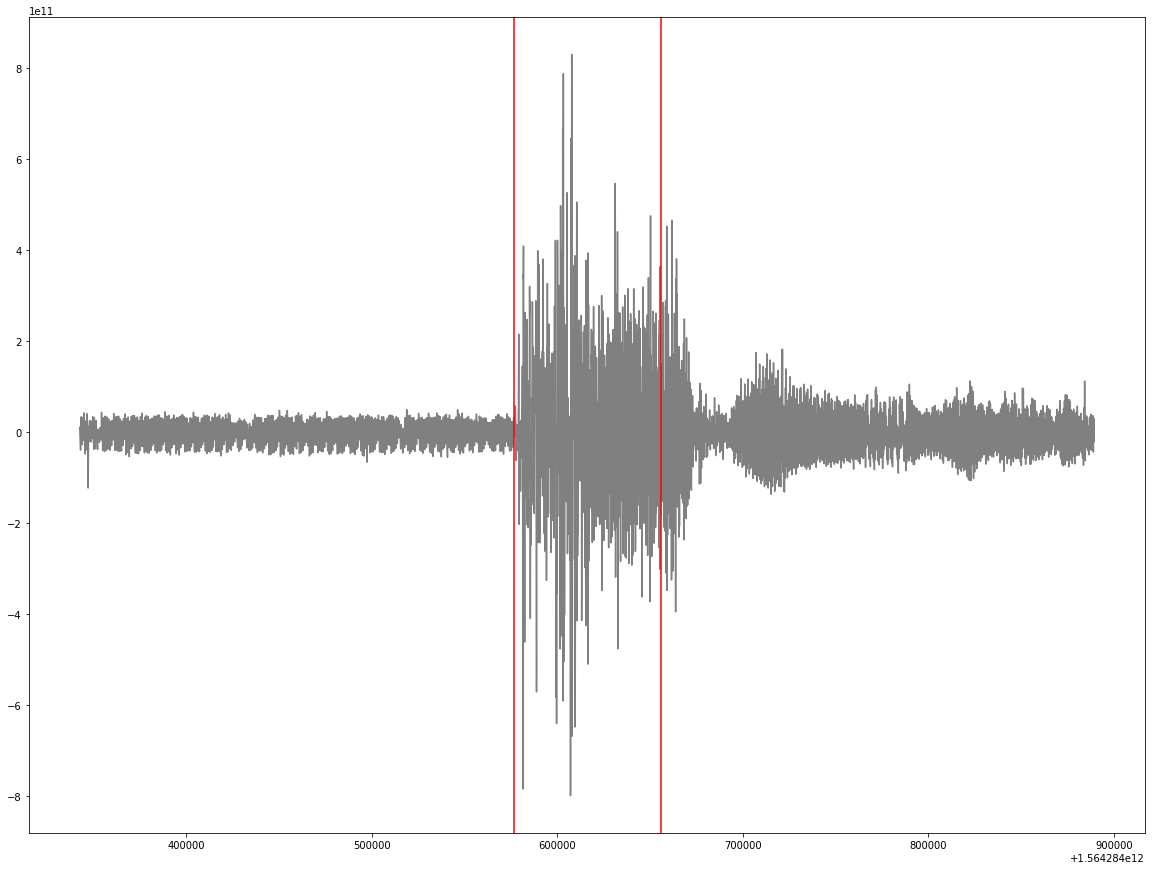

In [9]:
# This is a visualization for preictal ictal and post-ictal period of seizure
df = pd.read_parquet("/content/drive/MyDrive/epi_data_folders/MSEL_00182/concat_data/00182_BVP.parquet")
df1 = df.iloc[(25974272 - 30000): (25974272 + 40000)]
plt.figure(figsize=(20, 15))
plt.plot(df1["time"], df1["BVP"],color='grey')
plt.axvline(x = 1564284577000, color = 'r')
plt.axvline(x = 1564284577000 + 78800, color = 'r')

from google.colab import files
plt.savefig("abc.png")
files.download("abc.png") 